   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]
Label counts after mapping: classification
1    250
0    150
Name: cou

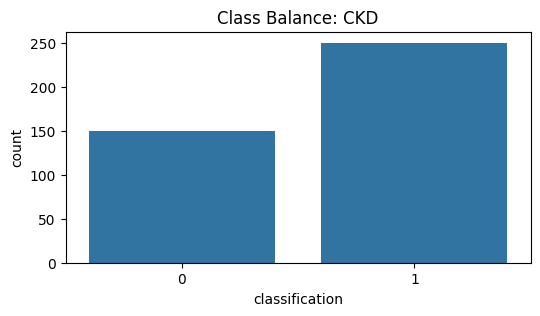

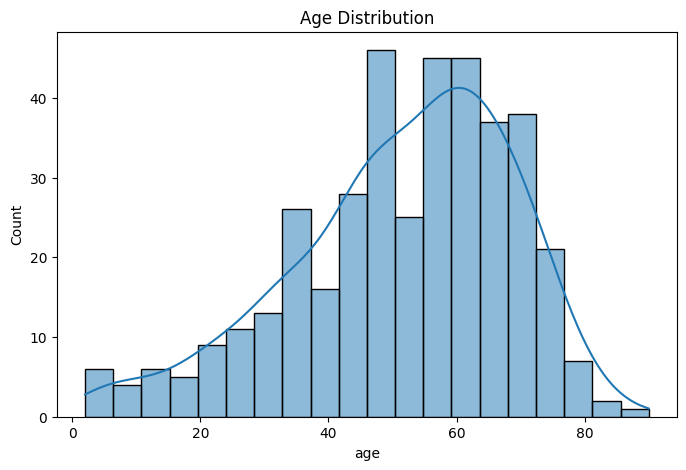

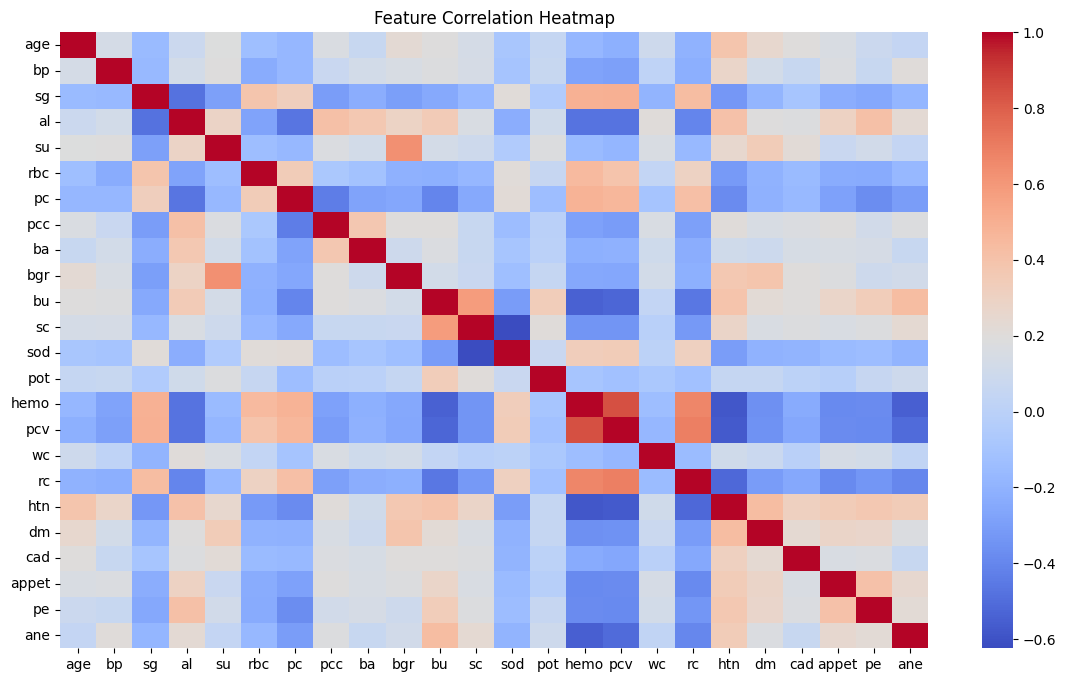

Logistic Regression CV accuracy: 0.997 ± 0.006
Test accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

----------------------------------------
Random Forest CV accuracy: 0.997 ± 0.006
Test accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

----------------------------------------
Gradient Boosting CV accuracy: 0.988 ± 0.025
Test accuracy: 1.000
              precision    recall  f1-score   support

           0 

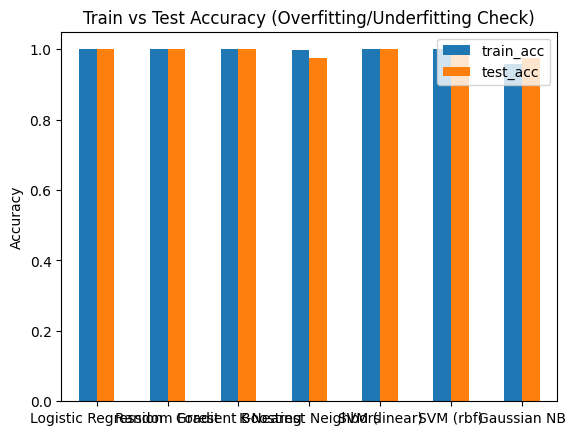

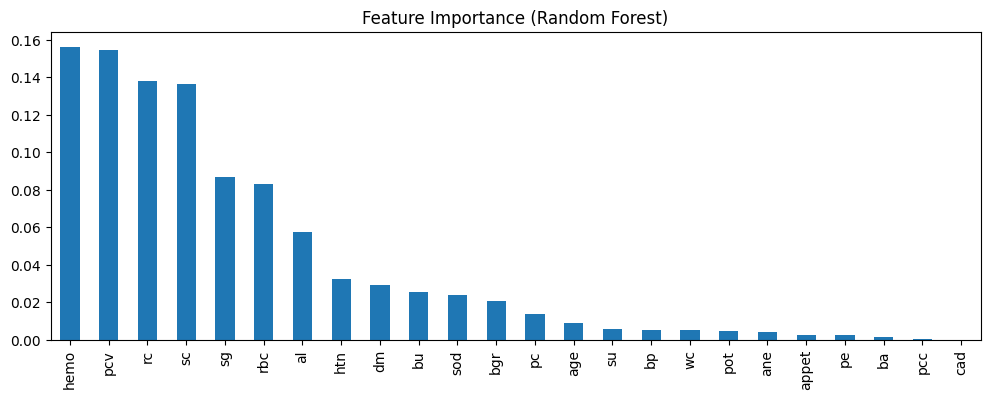

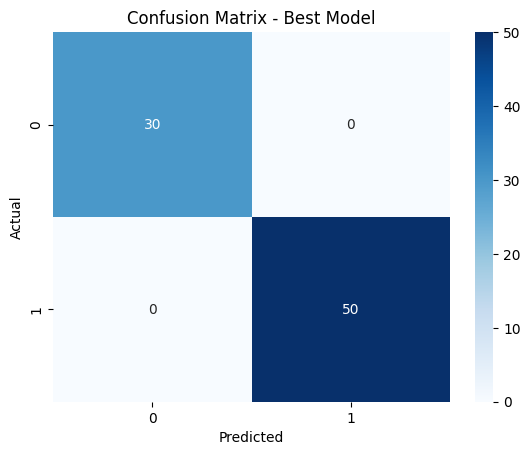

In [7]:
# 1. Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

# 2. Load Data
df = pd.read_csv('/content/kidney_disease.csv')  # Update path as needed

# 3. Clean column names and preview
df.columns = df.columns.str.strip().str.lower()
print(df.head())

# 4. --- Map the classification target BEFORE any numeric cleaning ---
df['classification'] = df['classification'].astype(str).str.strip().str.lower()
df['classification'] = df['classification'].apply(
    lambda x: 1 if x == 'ckd' or x.startswith('ckd') else 0
)
print("Label counts after mapping:", df['classification'].value_counts())
print("Labels:", df['classification'].unique())

# 5. --- Clean numeric columns (EXCLUDE 'classification') ---
def to_float(x):
    try:
        x = str(x).lower().replace('?', '').strip()
        if x == '' or x == 'nan':
            return np.nan
        if x.endswith('k'):
            return float(x[:-1]) * 1000
        typo_map = {'one':1,'ten':10,'twenty':20,'thirty':30,'forty':40,'fifty':50}
        if x in typo_map:
            return typo_map[x]
        return float(x.split()[0])  # Handles extra description
    except:
        return np.nan

numeric_cols = [
    'age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc'
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].apply(to_float)

# 6. --- Encode categorical columns except target ---
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != 'classification']
for col in cat_cols:
    df[col] = df[col].fillna('missing')
    df[col] = LabelEncoder().fit_transform(df[col])

# 7. --- Feature/Target split ---
X = df.drop(['classification','id'], axis=1, errors='ignore')
y = df['classification']

# 8. --- Impute missing values in features ---
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

# --- EDA: Class balance, Age, Feature correlation ---
plt.figure(figsize=(6, 3))
sns.countplot(x=df['classification'])
plt.title('Class Balance: CKD')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['age'].dropna(), bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 9. --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 10. --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 11. --- Model Setup ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100,random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM (linear)': SVC(kernel="linear", probability=True),
    'SVM (rbf)': SVC(kernel="rbf", probability=True),
    'Gaussian NB': GaussianNB()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 12. --- Cross-Validation and Test Performance ---
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"{name} CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred))
    print("-"*40)

# 13. --- Overfitting/Underfitting Analysis ---
fit_results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    fit_results[name] = {
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_test_pred)
    }
fit_df = pd.DataFrame(fit_results).T
fit_df.plot(kind='bar')
plt.title('Train vs Test Accuracy (Overfitting/Underfitting Check)')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.show()

# 14. --- Feature Importance (Tree models) ---
rf = models['Random Forest']
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp.plot(kind='bar', title='Feature Importance (Random Forest)', figsize=(12,4))
plt.show()

# 15. --- Confusion Matrix for Best Model ---
best_model = models['Gradient Boosting']
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
